In [387]:
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../../')

pd.set_option('display.max_columns', None)


# Read in data

In [388]:
original_df = pd.read_csv('../../data/imbalance_data/cleaned_08-01-2020_22_15_47 - 08-01-2020_22_15_47_355pm_data.csv')

In [389]:
original_df.drop('imbalancetype', inplace=True, axis=1)

In [390]:
original_df.shape

(6733, 22)

In [391]:
original_df.shape

(6733, 22)

In [392]:
imbal_train_df.shape

(6733, 20)

- Get p and L dataset

In [393]:
p_and_l_df = original_df[['close', 'lastprice_unnormalized']] # use this for p&l

In [394]:
imbal_train_df = original_df.loc[:, (original_df.columns!='close') &  (original_df.columns!='lastprice_unnormalized') ]

# take top cols
- Need to run all cells first

In [395]:
cols_to_select = list(X_train.columns[np.array(lr.coef_ > .0005).ravel()])

In [396]:
cols_to_select.append('pct_move_snapshot_to_close')
smaller_imbal_train_df = imbal_train_df.loc[:,imbal_train_df.columns.isin(cols_to_select)]

In [397]:
cols_to_select

['currentvolume',
 'nbo',
 'imbalancesize',
 'notional_imbalance',
 'currentreferenceprice',
 'nearindicativeprice',
 'farindicativeprice',
 'day',
 'year',
 'month',
 'pct_move_snapshot_to_close']

# Split into x and y

In [398]:
imbal_train_X = imbal_train_df.loc[:, imbal_train_df.columns != 'pct_move_snapshot_to_close']
imbal_train_y = imbal_train_df.loc[:, imbal_train_df.columns == 'pct_move_snapshot_to_close']

In [399]:
# # small cols
# smaller cols does worse
# imbal_train_X = smaller_imbal_train_df.loc[:, smaller_imbal_train_df.columns != 'pct_move_snapshot_to_close']
# imbal_train_y = smaller_imbal_train_df.loc[:, smaller_imbal_train_df.columns == 'pct_move_snapshot_to_close']

# train a model

In [400]:
p_and_l_test_df[['close','lastprice_unnormalized']]

,close,lastprice_unnormalized
106,86.52,86.5500
4234,57.95,57.8500
458,47.61,47.7700
5623,29.68,29.7053
3155,41.03,41.0200
...,...,...
2747,117.19,117.1300
5262,31.10,31.1750
84,82.30,82.1900
903,117.40,117.6400


In [440]:
mae = []
mae_above_threshold = []
mae_positive_predictions = []
mae_negative_predictions= [] 
n_correct_signs=[]

n_correct_sign_and_more_extreme_predictions = []
n_correct_sign_and_threshold = []
total_delta_close_last = []
len_correct=[]
threshold = .10
cv = 120

position_size_in_dollars=100_000
cost_per_1k_shares_entry_and_exit=6
# How much does it cost per share?
# $6 per 1k shares on entry and exit

for i in range(cv):
    if i % 20 == 0:
        print(f"PCT finished = {i/cv:.2%}")
    lr =LinearRegression()
    X_train, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.15) # RandomForestRegressor(n_jobs=-1) #ain, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.10)
    p_and_l_test_df = X_test.join(p_and_l_df)
    
    
    lr.fit(X_train, y_train )

    test_predictions = lr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions) )

    # what about more extreme predicitons, above threshold
    threshold_mask = np.abs(test_predictions) > threshold
    threshold_test_predictions = test_predictions[threshold_mask]
    threshold_y_test = y_test[threshold_mask]
    mae_above_threshold.append(mean_absolute_error(threshold_y_test, threshold_test_predictions))

    # are we better at positive or negative predictions?
    positive_mask = np.sign(test_predictions) == 1
    positive_predictions = test_predictions[positive_mask]
    positive_y_test = y_test[positive_mask]
    mae_positive_predictions.append(mean_absolute_error(positive_y_test, positive_predictions))

    negative_predictions = test_predictions[np.sign(test_predictions) == -1]
    negative_y_test = y_test[np.sign(test_predictions) == -1]
    mae_negative_predictions.append(mean_absolute_error(negative_y_test, negative_predictions))

    # sign of prediction and more extreme signs
    len_correct.append(len(y_test))
    n_sign_and_extreme = []
    n_sign = []
    n_sign_and_threshold = []
    delta_close_last_array = []
    
    start_prices_running_sum = 0
    end_prices_running_sum = 0 # this should be higher
    
    prediction_index = 0
    for pred_, true_ in zip(test_predictions, np.array(y_test).ravel()):

        if (np.sign(pred_) == np.sign(true_) ) and (np.abs(true_) > np.abs(pred_)):
            n_sign_and_extreme.append(1)
        if (np.sign(pred_) == np.sign(true_) ) :
            n_sign.append(1)
        if (np.abs(pred_) > threshold) and (np.sign(pred_) == np.sign(true_) ) : 
            n_sign_and_threshold.append(1)
            
        if (np.abs(pred_) > threshold): ## get into a position here
            stock_direction_pred = np.sign(pred_) # direction stock is going to move
            
            # calculate P & l
            last_price =  p_and_l_test_df.iloc[prediction_index, :]['lastprice_unnormalized']
            
            close_price = p_and_l_test_df.iloc[prediction_index, :]['close']
            
            if stock_direction_pred > 0: # going up
                delta_close_last_pct = (close_price / last_price) - 1
                start_prices_running_sum += last_price 
                end_prices_running_sum += close_price
                
                if (prediction_index % 500 == 0) and (i % 20 == 0):
                    print('going up')
                    print('delta_close_last_pct=',delta_close_last_pct)
                    print('last_price=',last_price)
                    print('close_price=', close_price)
                    print('prediction_index=',prediction_index)
                    print(' ')

            
            else: # going down
                delta_close_last_pct = (last_price /close_price ) - 1
                start_prices_running_sum += close_price 
                end_prices_running_sum += last_price
                
                if (prediction_index % 500 == 0) and (i % 20 == 0):
                    print('prediction', pred_)
                    print('going down')
                    print('delta_close_last_pct=',delta_close_last_pct)
                    print('last_price=',last_price)
                    print('close_price=', close_price)
                    print('prediction_index=',prediction_index)
                    print(' ')

            delta_close_last_array.append(delta_close_last_pct)
                
            
        prediction_index += 1
            
            
            
                
    n_correct_sign_and_more_extreme_predictions.append(np.sum(n_sign_and_extreme))
    n_correct_signs.append(np.sum(n_sign))
    n_correct_sign_and_threshold.append(np.sum(n_sign_and_threshold))
    total_delta_close_last.append(np.median(delta_close_last_array))



PCT finished = 0.00%
prediction [-0.26495936]
going down
delta_close_last_pct= 0.0018909090909089432
last_price= 68.88
close_price= 68.75
prediction_index= 1000
 
PCT finished = 16.67%
prediction [-0.39074864]
going down
delta_close_last_pct= 0.002631953336178494
last_price= 140.95
close_price= 140.58
prediction_index= 500
 
prediction [-0.23566576]
going down
delta_close_last_pct= 0.0013368983957218195
last_price= 14.98
close_price= 14.96
prediction_index= 1000
 
PCT finished = 33.33%
prediction [-0.15646589]
going down
delta_close_last_pct= -0.0004954582989263878
last_price= 121.04
close_price= 121.1
prediction_index= 0
 
prediction [-0.13443001]
going down
delta_close_last_pct= -0.0006618133686300265
last_price= 45.3
close_price= 45.33
prediction_index= 1000
 
PCT finished = 50.00%
prediction [-0.30898871]
going down
delta_close_last_pct= 0.0050493716337520755
last_price= 89.57
close_price= 89.12
prediction_index= 0
 
prediction [-0.14917718]
going down
delta_close_last_pct= -0.0002

In [441]:
start_prices_running_sum

52526.409999999916

In [442]:
end_prices_running_sum

52583.773800000024

In [443]:
end_prices_running_sum / start_prices_running_sum -1

0.0010920944340211403

In [444]:
delta_close_last_array[:10]

[0.004425630171252637,
 0.0020664003306238854,
 0.0006338139755981409,
 -0.00031523011798606504,
 -0.015090543259557387,
 0.0,
 0.002583372475340573,
 0.002122541389557142,
 0.002539360081259323,
 -0.0025500196155354704]

In [445]:

end_prices_running_sum

52583.773800000024

In [446]:
start_prices_running_sum


52526.409999999916

In [447]:
print(f"median mae for negative predictions = {np.median(mae_negative_predictions):.2%}")
print(f"median mae for positive predictions = {np.median(mae_positive_predictions):.2%}") # slightly better as positive predictions
print(f"median MAE with threshold predictions = {np.median(mae_above_threshold):.2%}")
print(f"median MAE with all data is {np.median(mae):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data is {np.sum(n_correct_signs)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data and the true data is more extreme {np.sum(n_correct_sign_and_more_extreme_predictions)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold \
    of {threshold} =  {np.sum(n_correct_sign_and_threshold)/np.sum(len_correct):.2%}")
print(f"The expected profit in pct per dollar  put in is {(end_prices_running_sum / start_prices_running_sum) - 1:.6%}")


median mae for negative predictions = 22.74%
median mae for positive predictions = 21.44%
median MAE with threshold predictions = 24.40%
median MAE with all data is 22.52%
pct of the time we guess the corect sign (up or down) all data is 61.13%
pct of the time we guess the corect sign (up or down) all data and the true data is more extreme 37.76%
pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold     of 0.1 =  39.38%
The expected profit in pct per dollar  put in is 0.109209%


In [448]:
np.median(delta_close_last_array)*100

0.085937207085518

# Threshold predictions

In [119]:
# Threshold predictions
N = 30
for test, true in zip(test_predictions[threshold_mask].ravel()[:N], np.array(y_test)[threshold_mask].ravel()[:N]):
    print(' ')
    print('True move = ', true)
    print('Predicted move =', test)

 
True move =  0.06
Predicted move = -0.11548068292224656
 
True move =  0.06
Predicted move = -0.22869827708650742
 
True move =  -0.06
Predicted move = -0.22519892308461553
 
True move =  -0.13
Predicted move = -0.2251772624813347
 
True move =  -0.27
Predicted move = -0.37562180227024233
 
True move =  -0.12
Predicted move = -0.11545169689870577
 
True move =  -0.07
Predicted move = -0.156785177536759
 
True move =  -0.27
Predicted move = -0.200676989494221
 
True move =  0.0
Predicted move = -0.20730996730590892
 
True move =  -0.24
Predicted move = -0.101309440929373
 
True move =  0.08
Predicted move = -0.10818534754875991
 
True move =  -0.27
Predicted move = -0.22439599154226136
 
True move =  -0.03
Predicted move = -0.12056162829826417
 
True move =  0.17
Predicted move = -0.22380753873438108
 
True move =  -0.33
Predicted move = -0.10106982419365579
 
True move =  0.14
Predicted move = -0.14450701944703637
 
True move =  -0.6
Predicted move = -0.28162429637614395
 
True move 

In [11]:
N = 30
for test, true in zip(test_predictions.ravel()[:N], np.array(y_test).ravel()[:N]):
    print(' ')
    print('True move = ', true)
    print('Predicted move =', test)

 
True move =  0.18
Predicted move = -0.07930251947141809
 
True move =  0.3
Predicted move = 0.0782097197416683
 
True move =  0.13
Predicted move = 0.08096606920120075
 
True move =  -0.22
Predicted move = -0.18268469858625025
 
True move =  0.04
Predicted move = -0.207499002409109
 
True move =  0.06
Predicted move = -0.09908016692762289
 
True move =  0.07
Predicted move = -0.0741316035189794
 
True move =  -0.03
Predicted move = -0.22033569101532563
 
True move =  -0.57
Predicted move = -0.09630914352613101
 
True move =  -0.01
Predicted move = -0.031568716245996276
 
True move =  -0.35
Predicted move = -0.2669185753964738
 
True move =  -0.32
Predicted move = -0.1308466734391216
 
True move =  -0.39
Predicted move = -0.10122170269306663
 
True move =  0.0
Predicted move = -0.14955906989197065
 
True move =  0.0
Predicted move = -0.20194275215730717
 
True move =  -0.13
Predicted move = -0.19806921260167448
 
True move =  0.15
Predicted move = -0.04437765399822291
 
True move =  0

# How often do we get the sign correct

In [12]:
n_correct_signs = 0
for test, true in zip(test_predictions.ravel(), np.array(y_test).ravel()):
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

In [13]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.6379821958456974

# What about the correct sign for threshold (<=15%) moves?

In [14]:
n_correct_signs = 0
for test, true in zip(test_predictions[threshold_mask].ravel(), np.array(y_test)[threshold_mask].ravel()):
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

In [15]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.27596439169139464

# What about the correct sign for positive moves?

In [93]:
n_correct_signs = 0
for test, true in zip(test_predictions[positive_mask].ravel(), np.array(y_test)[positive_mask].ravel()):
    print(test,true)
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

0.03897668679327726 -0.13
0.09338163434165914 0.38
0.007832537663091887 -0.15
0.015575505480803553 -0.08
0.11422734308074789 -0.97
0.001463058716064669 -0.25
0.04263202085119078 0.13
0.0757983096877588 0.38
0.032505399644353616 0.0
0.11430143777177992 0.24
0.016740128863899528 0.0
0.02883943183858051 0.07
0.0841982931590155 0.05
0.060664187656377155 -0.32
0.04091794811316385 -0.02
0.026874645715552203 -0.29
0.147709736148669 0.02
0.08643732687922512 0.21
0.07464296765413136 -0.11
0.09800826831894272 0.15
0.0972293541291398 1.7
0.06968099174404196 0.0
0.11693594655278083 -0.19
0.05994698062990711 0.12
0.05703986552012319 -0.24
0.04577875750867211 -0.02
0.02811885218518917 0.28
0.08867122088054158 -0.48
0.08601229724986492 -0.09
0.041304136319579854 0.33
0.08834565421381635 1.24
0.06795449487212268 -0.01
0.11072116523458275 0.04
0.12008975761464091 -0.13
0.05509689569789078 -0.57
0.0867397082652257 0.12
0.07043633339729283 0.0
0.004010448815839424 0.17
0.08720239896443482 0.16
0.00711157

In [94]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.09495548961424333

# Coefficients

In [123]:
lr.coef_

array([[ 2.86735429e-01,  6.01592271e+02, -1.05897452e-01,
        -6.02500796e+02,  4.89263969e-01,  5.54624959e-01,
        -3.32669472e+00,  2.25797336e-01,  1.61684133e-01,
         2.94946601e-01]])

In [ ]:
X_train

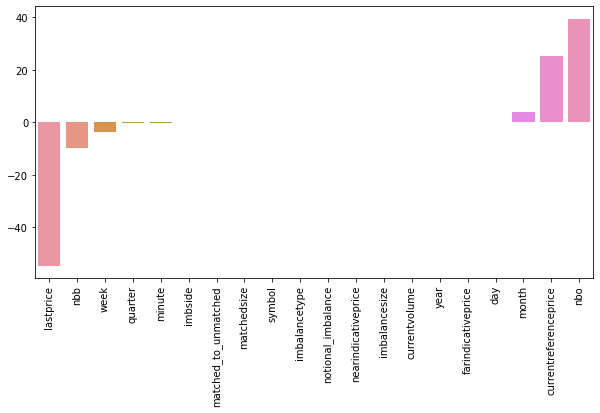

In [254]:
plt.figure(figsize=(10,5))
sns.barplot(x = X_train.columns[np.argsort(lr.coef_).ravel()], y = lr.coef_.ravel()[np.argsort(lr.coef_).ravel()])
plt.xticks(rotation=90) ;

In [19]:
 lr.coef_.ravel()[np.argsort(lr.coef_).ravel()]

array([-7.86854820e+02, -3.83651791e+02, -6.22514812e+00, -1.73024488e+00,
       -7.53218479e-01, -3.58735516e-01, -2.68781227e-01, -1.79862432e-01,
       -2.75760593e-02,  2.75299783e-11,  7.00108438e-02,  1.23456755e-01,
        1.38178306e-01,  2.77456436e-01,  3.64226488e-01,  6.46225303e-01,
        6.79975346e-01,  7.14074050e+00,  1.88381243e+02,  9.81319399e+02])